# METODOLOGIA BASEADA EM CIÊNCIA DE REDES PARA ANÁLISE DE COMUNIDADES EM REDES SOCIAIS COM GEOLOCALIZAÇÃO

## Autor: ERIC LEAL

### Detalhes do Projeto
Em desenvolvimento...



## Importando as bibliotecas

In [16]:
import pandas as pd
import numpy as np
import json
import random
import time
# from community_layout.layout_class import CommunityLayout
# from community import community_louvain
# from matplotlib.colors import CSS4_COLORS
# import graphviz as gv
# import pygraphviz as pgv

from pandas import json_normalize
import networkx as nx
# from networkx.drawing.nx_agraph import to_agraph
# from networkx.drawing.nx_pydot import to_pydot


import matplotlib.pyplot as plt
import utm
import math
import csv
import geopandas as gpd
# from libpysal.weights import Rook

from tqdm.contrib.concurrent import thread_map

import os
# import tweepy
# from dotenv import load_dotenv
from shapely import geometry

# Required Libraries
from tqdm import tqdm as tqdmBasic

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
# from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation

import seaborn as sns; sns.set_theme()

import GeosocialAlgorithms as ga
from scipy.cluster.hierarchy import ward, fcluster


## Configurando a API

In [ ]:
# Load the .env file
# load_dotenv()

# # Get the keys from the .env file
# consumer_key = os.environ.get('TWITTER_API_KEY')
# consumer_secret = os.environ.get('TWITTER_API_KEY_SECRET')
# access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
# access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')
# bearer_token = os.environ.get('TWITTER_BEARER_TOKEN')

# # Authenticate with the twitter API
# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_token_secret)

# # Create the API object
# api = tweepy.API(auth, wait_on_rate_limit=True)

## Carregando dados existententes caso existam

In [ ]:
# Dicionario a ser preenchido com chaves sendo o author_id e os valores sendo o username
if os.path.exists(r'E://Dict_Author_Id_to_Username.json'):
    with open(r'E://Dict_Author_Id_to_Username.json', 'r') as fp:
        author_id_to_username = json.load(fp)
        print(f"Foram carregadas {len(author_id_to_username)} chaves do arquivo JSON")
else:
    author_id_to_username = {}

In [ ]:
df_mean = pd.read_csv(r"E:/DataFrameUsernameMeansMedians.csv", sep=";", header=0)
# df_mean.columns = ["username", "mean_lat", "mean_lon", "median_lat", "median_lon", "mean_X", "mean_Y", "median_X", "median_Y"]
df_mean.head()

In [ ]:
df_mean = df_mean.drop(0)
df_mean.head()

In [ ]:
username_to_find = ""
is_equal = df_mean['username'] == username_to_find

In [ ]:
print(df_mean[df_mean['username'] == username_to_find])

In [ ]:
dfTopAuthorsProjected = pd.read_csv("E://TopAuthorsProjected.csv")

In [ ]:
with open(r'E:/dictMentions_locations.json', 'r') as f:
    dictMentions = json.load(f)

In [ ]:
for k, v in dictMentions.items():
    if "" in v:
        print(k, v)

In [2]:
grafo_twitter = nx.read_graphml("D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_twitter.graphml")
grafo_twitter_conexo = nx.read_graphml("D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_twitter_conexo.graphml")

grafo_fluxo_secao = nx.read_graphml("D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_fluxo_secao.graphml")
grafo_fluxo_freguesia = nx.read_graphml("D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_fluxo_freguesia.graphml")
grafo_fluxo_municipio = nx.read_graphml("D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_fluxo_municipio.graphml")

grafo_regioes_secao = nx.read_graphml("D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_regioes_secao.graphml")  
grafo_regioes_freguesia = nx.read_graphml("D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_regioes_freguesia.graphml")
grafo_regioes_municipio = nx.read_graphml("D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_regioes_municipio.graphml")

In [ ]:
grafo_twitter.number_of_nodes(), grafo_twitter.number_of_edges()

In [ ]:
grafo_twitter_copy = grafo_twitter.copy()

for node in grafo_twitter.nodes():
    if node == "" or node == " " or node is None:
        grafo_twitter_copy.remove_node(node)

In [ ]:
nx.write_graphml_lxml(grafo_twitter_copy, "D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_twitter.graphml")

In [ ]:
gdf_wgs84_secao = gpd.read_file(r"C:\Users\Cliente\OneDrive\UNIRIO\TCC\GPK\Seccao_Area_de_Interesse.shp")
gdf_wgs84_freguesia = gpd.read_file(r"C:\Users\Cliente\OneDrive\UNIRIO\TCC\GPK\Freguesia_Area_de_Interesse.shp")
gdf_wgs84_municipio = gpd.read_file(r"C:\Users\Cliente\OneDrive\UNIRIO\TCC\GPK\Municipio_Area_de_Interesse.shp")

crs = "EPSG:4326"

gdf_wgs84_secao = gdf_wgs84_secao.to_crs(crs)
gdf_wgs84_freguesia = gdf_wgs84_freguesia.to_crs(crs)
gdf_wgs84_municipio = gdf_wgs84_municipio.to_crs(crs)

In [ ]:
gdf_users = gpd.read_file(r"E:\Usernames_Com_Coordenadas_Localidade.csv")
gdf_users['geometry'] = gdf_users.apply(lambda x: geometry.Point(x['median_lon'], x['median_lat']), axis=1)

## Carregando métodos

In [ ]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [ ]:
def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data

In [ ]:
def dataframe_standartization(data_frame: pd.DataFrame, columns: list = []) -> pd.DataFrame:
    data_frame.drop(columns=columns, inplace=True)
    data_frame = data_frame.fillna(0)
    
    dictCoordByUser = {}

    for index, row in tqdmBasic(data_frame.iterrows(), total=data_frame.shape[0]):
        if row['username'] not in dictCoordByUser:
            dictCoordByUser[row['username']] = {
                'lat': [],
                'lon': []
            }        
            
        dictCoordByUser[row['username']]['lat'].append(row['lat'])
        dictCoordByUser[row['username']]['lon'].append(row['lon'])
        
    df_mean = pd.DataFrame(columns=["username", "mean_lat", "mean_lon", "median_lat", "median_lon"])

    for key in tqdmBasic(dictCoordByUser.keys()):
        df_mean = df_mean._append({
            "username": key,
            "mean_lat": np.mean(dictCoordByUser[key]['lat']),
            "mean_lon": np.mean(dictCoordByUser[key]['lon']),
            "median_lat": np.median(dictCoordByUser[key]['lat']),
            "median_lon": np.median(dictCoordByUser[key]['lon'])
        }, ignore_index=True)
        
    return df_mean

In [ ]:
def gera_dict_mentions_by_user(data_frame: pd.DataFrame, data_frame2:pd.DataFrame = None,  mentions_unicas = True) -> dict:
    if data_frame2 is not None:
        mentions_usuario = {}
        
        for index, row in tqdmBasic(data_frame2.iterrows(), total=data_frame2.shape[0]):
            if row['username'] not in mentions_usuario:
                mentions_usuario[row['username']] = [row_base[0]['username'] for row_base in data_frame[data_frame['username'] == row['username']]['entities_mentions'].tolist() 
                                                     if row_base is not None]    
    else:
        data_editado = data_frame['entities_mentions']
        data_editado.dropna(inplace=True)
        # dataEditado.reset_index(drop=True, inplace=True)
        data_editado = data_editado.to_frame()
        
        mentions_usuario = {}

        # Percorrendo teste1 e adicionando os usernames no dicionário usando o id do usuário como chave
            
        for mention in tqdmBasic(data_editado.itertuples(), total=data_editado.shape[0]):
            usuarios_mencionados = []
            
            coluna = 'author_id' #'username' if data_frame['username'].at[mention.Index] != '' else 'author_id'
            
            if data_frame[coluna].at[mention.Index] not in mentions_usuario:
                mentions_usuario[data_frame[coluna].at[mention.Index]] = []
                
            for usuario in mention[1]:
                usuarios_mencionados.append(usuario['username'])
                mentions_usuario[data_frame[coluna].at[mention.Index]].extend(usuarios_mencionados)
        
    if mentions_unicas:
        mentions_usuario = {k: list(dict.fromkeys(v)) for k, target in mentions_usuario.items()}
        
    return mentions_usuario

In [ ]:
def geraDictLinkTweets(data_frame) -> list:
    dataEditado = data_frame['entities_urls']
    dataEditado.dropna(inplace=True)
    # dataEditado.reset_index(drop=True, inplace=True)
    dataEditado = dataEditado.to_frame()
    
    linksTweets = {}

    # Percorrendo teste1 e adicionando os usernames no dicionário usando o id do usuário como chave
        
    contador = 1
    for link in dataEditado.itertuples():
        print(f"Link {contador} de {dataEditado.shape[0]}")
        
        linksTweet = []
        if data_frame['author_id'].at[link.Index] not in linksTweets:
            linksTweets[data_frame['author_id'].at[link.Index]] = []
            
        for linkTweet in link[1]:
            linksTweet.append(linkTweet['expanded_url'])
            linksTweets[data_frame['author_id'].at[link.Index]].extend(linksTweet)
        contador += 1
        
    return linksTweets

In [ ]:
def returnMediaDictListas(dict : dict) -> float:
    soma = 0
    for key in dict:
        soma += len(dict[key])
    return soma/len(dict)

In [ ]:
def get_username(author_id: str):
    """Recupera o username do usuário a partir do author_id e atualiza o dicionário author_id_to_username

    Args:
        author_id: O id do usuário 
    """
    if author_id in author_id_to_username.keys():
        return
    
    author_id_to_username[author_id] = ''
    try:
        user = api.get_user(user_id=author_id)  
        author_id_to_username[author_id] = user.screen_name
    except:
        pass

In [ ]:
def returnDataFrameWithUsernames(dataFrame : pd.DataFrame) -> pd.DataFrame:      
    dataFrame['username'] = ''
    
    thread_map(get_username, [id for id in dataFrame['author_id']], max_workers=16, total=dataFrame.shape[0])
        
    for index, row in dataFrame.iterrows():
        dataFrame['username'].at[index] = author_id_to_username[row['author_id']]
    
    return dataFrame

In [ ]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[target for k, target in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

In [ ]:
def processRawData(data : dict | list[dict]) -> pd.DataFrame:
    data_frame = json_normalize(data,record_path = ['data'], sep = '_', errors ='ignore')
        
    data_frame['lat'] = data_frame['geo_coordinates_coordinates'].str.get(1)
    data_frame['lon'] = data_frame['geo_coordinates_coordinates'].str.get(0)

    #cleaning fields that will not be used
    try:
        # del data_frame['entities_mentions']
        del data_frame['context_annotations']
        # del data_frame['entities_urls']
        # del data_frame['entities_cashtags']
        del data_frame['withheld_copyright']
        del data_frame['withheld_country_codes']
        del data_frame['withheld_scope']
    except:
        pass
    
    return data_frame

In [ ]:
def process_file(file: str) -> pd.DataFrame:
    """Processa um arquivo JSONL e retorna um dataframe

    Args:
        file (str): Caminho do arquivo JSONL

    Returns:
        pd.DataFrame: Dataframe com os dados do arquivo JSONL
    """
    print(f"Processando arquivo {file}")
    df = json_normalize(load_jsonl(file), sep='_', errors='ignore')
    return df

In [ ]:
def convert_to_utm(df: pd.DataFrame, columnLat: str = "latitude", columnLon: str = "longitude", outColumnX: str = "x", outColumnY: str = "y") -> pd.DataFrame:
  """Converte as coordenadas de latitude e longitude para UTM zona 29.

  Args:
      df (pd.DataFrame): Dataframe com as coordenadas de latitude e longitude.
      columnLat (str, optional): Coluna que contém a latitude. Defaults to "latitude".
      columnLon (str, optional): Coluna que contém a longitude. Defaults to "longitude".
      outColumnX (str, optional): Coluna saída em UTM para o eixo X. Defaults to "x".
      outColumnY (str, optional): Coluna saída em UTM para o eixo Y. Defaults to "y".

  Returns:
      pd.DataFrame: Dataframe atualizado com as coordendas em UTM.
  """
  # Obtém as coordenadas de latitude e longitude.

  lat = df[columnLat].values
  lon = df[columnLon].values

  # Converte para UTM.

  easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)

  # Adiciona as colunas `mean_X` e `mean_Y` ao dataframe.

  df[outColumnX] = easting
  df[outColumnY] = northing

  return df

In [ ]:
def get_expanded_urls(row):
    """
    Retorna uma lista com as URLs expandidas do tweet.

    Args:
        row: Uma linha do dataframe.

    Returns:
        Uma lista com as URLs expandidas do tweet.
    """

    if row['entities_urls']:
        expanded_urls = [url['expanded_url'] for url in row['entities_urls']]
    else:
        expanded_urls = []
    return expanded_urls

In [ ]:
def associateNodes(row):
    G = nx.DiGraph()
    vertex = row['username'] if row['username'] != '' else row['author_id']
    
    if vertex not in G.nodes():
        G.add_node(vertex)
        
    if row['entities_mentions']:
        for mention in row['entities_mentions']:
            mention_username = mention['username']
            if mention_username not in G.nodes():
                G.add_node(mention_username)
            G.add_edge(vertex, mention_username)
    
    return G

In [ ]:
def calculateDistance(xP1: float, yP1: float, xP2: float, yP2: float):
    P1 = [xP1, yP1]
    P2 = [xP2, yP2]
    
    return math.dist(P1, P2)

In [ ]:
def calculateDistances(graph, generalizationLimit = None):
  nodes_with_median = [node for node in graph.nodes if "median_X" in graph.nodes[node]]
  
  print(f"Existem {len(nodes_with_median)} nós com mediana.")
  
  distances = {}
  
  for node in tqdmBasic(nodes_with_median):
    for other_node in nodes_with_median:
        if node == other_node:
            continue
        
        # print(f"Calculando distância entre {node} e {other_node}")
        
        distance = calculateDistance(
            graph.nodes[node]["median_X"], graph.nodes[node]["median_Y"], graph.nodes[other_node]["median_X"], graph.nodes[other_node]["median_Y"]
        )
        if generalizationLimit is not None:
            generaralized_distance = int(distance//generalizationLimit)
            if generaralized_distance not in distances.keys():
                distances[generaralized_distance] = 1
            else:
                distances[generaralized_distance] += 1
        else:
            if distance not in distances.keys():
                distances[distance] = 1
            else:
                distances[distance] += 1
            
        # distancesFromNode[node].append(distance)
  
  
  return distances

In [ ]:
def plotScatterEmpyricalComplementarDistribution(distances, output_path: str = 'E://', output_file_name: str = 'empyrical_complementar_distribution.png', show: bool = False, log: bool = False):
    """Plota o gráfico de dispersão da distribuição empírica complementar.

    Args:
        distances (list): Lista com as distâncias.
        output_path (str): Caminho de saída do arquivo.
        output_file_name (str): Nome do arquivo de saída.
        show (bool): Se o gráfico deve ser exibido.
    """    
    # sort the distances

    # calculate the probability of each distance
    if isinstance(distances, dict):
        keys_in_order = sorted(distances.keys())
        length_distances = sum(distances.values())
        dist = 1
        prob = []
        print(f"keys_in_order: {keys_in_order}")
        print(f"length_distances: {length_distances}")
        
        distances_list = [key for key, value in distances.items() for _ in tqdmBasic(range(value))]
        n = len(distances_list)
        prob = [1 - (i+1)/n for i in tqdmBasic(range(0,n))]
                    
        distances = list(distances.keys())
        
    else:
        distances.sort()
        if log == True:
            prob = [np.log10(1 - (i/len(distances))) for i in tqdmBasic(range(len(distances)), desc="Calculando probabilidade")]
        else:
            prob = [1 - (i/len(distances)) for i in tqdmBasic(range(len(distances)))]
            
    print(type(prob))

    # plot the scatter graph
    plt.figure(figsize=(180, 120))
    plt.scatter(distances, prob)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel("Distância")
    plt.ylabel("Probabilidade")
    plt.savefig(f"{output_path}{output_file_name}", dpi=300, bbox_inches='tight')
    
    if show:
        plt.show()
       

### Métodos de geração de grafos

In [ ]:
def generate_flow_graph(graph: nx.Graph, gdf: gpd.GeoDataFrame, column: str = 'geometry'):
    """Gera um grafo de fluxo a partir de um grafo existente e um GeoDataFrame com as regiões de interesse.

    Args:
        graph (nx.graph): Grafo base de onde será gerado o grafo de fluxo.
        gdf (gpd.GeoDataFrame): GeoDataFrame com os dados geográficos das regiões de interesse.
        column (str, optional): coluna alvo com o código de interesse. Defaults to 'geometry'.
        
    """
    
    grafo_fluxo = nx.DiGraph()
    no_sem_regiao = []
    
    for source, target in tqdmBasic(graph.edges(), total=graph.number_of_edges()):
        if source in no_sem_regiao and target in no_sem_regiao:
            continue
        
        u = graph.nodes[source]
        v = graph.nodes[target]
        
        try:
            u['median_lat']
        except:
            no_sem_regiao.append(source)
            continue
        
        try:
            v['median_lat']
        except:
            no_sem_regiao.append(target)
            continue
        
        u_region = gdf[gdf.contains(geometry.Point(float(u['median_lon']), float(u['median_lat'])))][column]
        v_region = gdf[gdf.contains(geometry.Point(float(v['median_lon']), float(v['median_lat'])))][column]
                
        if u_region.empty:
            no_sem_regiao.append(source)
            continue
        
        if v_region.empty:
            no_sem_regiao.append(target)
            continue
        
        if u_region.index[0] == v_region.index[0]:
            continue        
        
        if grafo_fluxo.has_edge(u_region.values[0], v_region.values[0]):
            grafo_fluxo[u_region.values[0]][v_region.values[0]]['weight'] += 1
        else:
            grafo_fluxo.add_edge(u_region.values[0], v_region.values[0], weight=1)
        
        # if (u_region.index[0], v_region.index[0]) not in grafo_fluxo.edges():
        #     grafo_fluxo.add_edge(u_region.index[0], v_region.index[0], weight=1)
        # else:
        #     grafo_fluxo[u_region.index[0]][v_region.index[0]]['weight'] += 1        
    
    return grafo_fluxo, no_sem_regiao

In [ ]:
def generate_graph_from_gdf(gdf: gpd.GeoDataFrame, column: str = 'geometry') -> nx.Graph:
    """Gera um grafo a partir de um GeoDataFrame.

    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame com os dados.
        column (str, optional): Nome da coluna de referência. Defaults to 'geometry'.

    Returns:
        nx.Graph: Grafo gerado.
    """
    G = nx.Graph()

    for index, row in tqdmBasic(gdf.iterrows(), total=gdf.shape[0]):
        vertex = row[column]
        adjacent_regions = gdf[gdf.geometry.touches(row['geometry'])][column]
        
        for adjacent_region in adjacent_regions:
            G.add_edge(vertex, adjacent_region)
            
    return G

In [ ]:
for node in grafo_twitter.nodes():
    print(grafo_twitter.nodes[node])
    break

### Métodos de cálculos com a rede

In [ ]:
for node in tqdmBasic(grafo_twitter_conexo.nodes(), total=grafo_twitter_conexo.number_of_nodes()):
    if 'median_lat' not in grafo_twitter_conexo.nodes[node]:
        continue
    
    x_median = df_mean.loc[df_mean['username'] == node, 'median_X'].values[0]
    y_median = df_mean.loc[df_mean['username'] == node, 'median_Y'].values[0]

    grafo_twitter_conexo.nodes[node]['median_X'] = x_median
    grafo_twitter_conexo.nodes[node]['median_Y'] = y_median

In [3]:
def show_graph_metrics(graph):
    degrees = []

    for node in graph.nodes():
        degrees.append(nx.degree(graph, node))
        
    print(f"Nº de nós: {graph.number_of_nodes()}")
    print(f"Nº de links: {graph.number_of_edges()}")
    print(f"Grau médio: {np.mean(degrees)}")
    print(f"Densidade: {nx.density(graph)}")
    print(f"Cluster global: {nx.transitivity(graph)}")
    print(f"Cluster médio: {nx.average_clustering(graph)}")

In [ ]:
# import networkx as nx

# Assuming you have a graph object named 'graph'
# You can replace 'graph' with your actual graph object

# Get the first ten nodes
nodes = list(grafo_twitter_conexo.nodes())[:10]

# Print the nodes and their attributes
for node in nodes:
    attributes = grafo_twitter_conexo.nodes[node]
    print(f"Node: {node}")
    print(f"Attributes: {attributes}")
    print("--------------------")


In [ ]:
def calculate_geostatistics(graph: nx.graph = None, df: pd.DataFrame = None, column: str = 'comunidade') -> dict:
    """Calcula as estatísticas geográficas de um grafo.

    Args:
        graph (nx.graph): Grafo a ser analisado.
        

    Returns:
        dict: Dicionário com as estatísticas calculadas.
        
    Raises:
        ValueError: Se não for fornecido um grafo ou um dataframe.
    """
    stats = {}
    
    if graph is not None:
        for node in tqdmBasic(graph.nodes(), total=graph.number_of_nodes()):
            community = graph.nodes[node][column]
            if community not in stats.keys():
                stats[community] = {
                    'x_points': [],
                    'y_points': [],
                    'x_mean': 0.0,
                    'y_mean': 0.0,
                    'mean_distance_to_center': 0.0,
                    'standard_deviation': 0.0,
                }
                
            if 'median_X' not in graph.nodes[node]:
                continue
            
            x = float(graph.nodes[node]['median_X'])
            y = float(graph.nodes[node]['median_Y'])
            
            stats[community]['x_points'].append(x)
            stats[community]['y_points'].append(y)
            
            
    elif df is not None:
        for index, row in tqdmBasic(df.iterrows(), total=df.shape[0]):
            community = row[column]
            if community not in stats.keys():
                stats[community] = {
                    'x_points': [],
                    'y_points': [],
                    'x_mean': 0.0,
                    'y_mean': 0.0,
                    'mean_distance_to_center': 0.0,
                    'standard_deviation': 0.0,
                }
                
            if 'median_X' not in row:
                continue
            
            x = float(row['median_X'])
            y = float(row['median_Y'])
            
            stats[community]['x_points'].append(x)
            stats[community]['y_points'].append(y)
    else:
        raise ValueError("You must provide a graph or a dataframe.")        
        
    for community in stats.keys():
        x_mean = np.mean(stats[community]['x_points'])
        y_mean = np.mean(stats[community]['y_points'])
        
        stats[community]['x_mean'] = x_mean
        stats[community]['y_mean'] = y_mean
        
        distances = [math.dist([x_mean, y_mean], [x, y]) for x, y in zip(stats[community]['x_points'], stats[community]['y_points'])]
        mean_distance_to_center = np.mean(distances)
        standart_deviation = np.std(distances)
        
        stats[community]['mean_distance_to_center'] = mean_distance_to_center
        stats[community]['standard_deviation'] = standart_deviation        
    
    return stats

In [ ]:
def return_community_detection_duration(graph: nx.Graph, algorithm: str = 'louvain'):
    """Calcula o tempo de execução de um algoritmo de detecção de comunidades.

    Args:
        graph (nx.Graph): Grafo a ser analisado.
        algorithm (str, optional): Algoritmo de detecção de comunidades. Defaults to 'louvain'.

    Returns:
        float: Tempo de execução do algoritmo.
        
    Raises:
        ValueError: Se o algoritmo não for implementado.
    """
    start = time.time()
    
    if algorithm == 'louvain':
        partition = nx.community.louvain_communities(graph)
        modularity = nx.community.modularity(graph, partition)
    elif algorithm == 'greedy':
        partition = nx.community.greedy_modularity_communities(graph)
        modularity = nx.community.modularity(graph, partition)
    elif algorithm == 'edge_betweeness':
        sets = random.randint(2, len(graph))        
        partition = nx.community.edge_betweenness_partition(graph, sets)
        modularity = nx.community.modularity(graph, partition)
    elif algorithm == 'girvan_newman':
        comunidades = list(nx.community.girvan_newman(graph))
        partition = comunidades[0]
        modularity = nx.community.modularity(graph, partition)
        
        for i in range(1, len(comunidades)):
            partition_partial = comunidades[i]
            modularity_partial = nx.community.modularity(graph, partition_partial)
            
            if np.abs(modularity_partial) > np.abs(modularity):
                partition = partition_partial
                modularity = modularity_partial
    else:
        raise ValueError("Método não implementado.")
        
    end = time.time()
    
    return end - start, partition, modularity

In [5]:
def random_subgraph_by_porcentage(graph: nx.DiGraph, porcentage: float = 0.1, connected_only: bool = False) -> nx.DiGraph:
    """Gera um subgrafo aleatório de um grafo.

    Args:
        graph (nx.Graph): Grafo base.
        porcentage (float, optional): Porcentagem de subgrafo. Defaults to 0.1.

    Returns:
        nx.Graph: Subgrafo gerado.
    """
    graph_return = nx.DiGraph()
    
    edges = random.sample(list(graph.edges()), int(graph.number_of_edges()*porcentage))
    graph_return.add_edges_from(edges)
    
    for node in graph_return.nodes():
        graph_return.nodes[node].update(graph.nodes[node])
        
    if connected_only:
        components = nx.weakly_connected_components(graph_return)
        biggest_component = max(components, key=len)
        connected_graph = graph_return.subgraph(biggest_component)
        return connected_graph
    
    return graph_return

In [ ]:
def compute_and_export_the_data_from_subgraphs(graph, output_path: str = 'E://', output_file_name: str = 'subgraph_data.csv', columns: list = ['Nós', 'Links'], porcentage: float = 0.1):

    output_file = os.path.join(output_path, output_file_name)

    try:
        df_performance = pd.read_csv(output_file, encoding='utf-8')
    except:
        df_performance = pd.DataFrame(columns=columns)
        
    tempo_louvain, comunidades_louvain, modularidade_louvain = return_community_detection_duration(graph, 'louvain')
    tempo_greedy, comunidades_greedy, modularidade_greedy = return_community_detection_duration(graph, 'greedy')
    # tempo_edge_betweeness = return_community_detection_duration(graph, 'edge_betweeness')    
    tempo_girvan_newman, comunidades_girvan_newman, modularidade_girvan_newman = return_community_detection_duration(graph, 'girvan_newman')

    df_performance = df_performance._append({
        "Porcentagem de Arestas": porcentage,
        "Nós": graph.number_of_nodes(),
        "Links": graph.number_of_edges(),
        "Grau Médio": np.mean([graph.degree(node) for node in graph.nodes()]),
        "Densidade": nx.density(graph),
        "Cluster Global": nx.transitivity(graph),
        "Cluster Médio": nx.average_clustering(graph),
        "Tempo Louvain": tempo_louvain,
        "N° Comunidades Louvain": len(comunidades_louvain),
        "Modularidade Louvain": modularidade_louvain,
        "Tempo Greedy": tempo_greedy,
        "N° Comunidades Greedy": len(comunidades_greedy),
        "Modularidade Greedy": modularidade_greedy,
        # "Tempo Edge Betweeness": tempo_edge_betweeness,
        "Tempo Girvan-Newman": tempo_girvan_newman,
        "N° Comunidades Girvan-Newman": len(comunidades_girvan_newman),
        "Modularidade Girvan-Newman": modularidade_girvan_newman
    }, ignore_index=True)

    df_performance.to_csv(output_file, index=False, encoding='utf-8')  

### Métodos de exportação de arquivos

In [ ]:
def _export_dictionary(dict : dict, path : str = 'E://', file_name : str = 'dict.json'):
    """Exporta um dicionário para um arquivo JSON

    Args:
        dict (dict): dicionário a ser exportado
        path (str, optional): Caminho do arquivo de saída. Defaults to ''.
        file_name (str, optional): Nome do arquivo de saída. Defaults to 'dict.json'.
    """                
    with open(f"{path}{file_name}", 'w') as f:
        json.dump(dict, f)

In [ ]:
def _export_list_to_csv(list : list, path : str = 'E://', file_name : str = 'list.csv'):
    """Exporta uma lista para um arquivo CSV

    Args:
        list (list): Lista a ser exportada
        path (str, optional): Caminho do arquivo de saída. Defaults to ''.
        file_name (str, optional): Nome do arquivo de saída. Defaults to 'list.csv'.
    """                
    with open(f"{path}{file_name}", 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(list)

## Criando os grafos

### Dataframes e dicionários base para os grafos

In [ ]:
dataFrameComUsernames = json_normalize(load_jsonl(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\dataWithUserNames.jsonl'), sep = '_', errors ='ignore') 

In [ ]:
dataFrameComUsernames2 = dataframe_standartization(dataFrameComUsernames)

In [ ]:
dictMentions = gera_dict_mentions_by_user(dataFrameComUsernames, data_frame2=dataFrameComUsernames2)

In [ ]:
_export_dictionary(dictMentions, 'E://', 'dictMentions_locations.json')

### Grafo de menções do twitter

#### Geração

In [ ]:
grafo_twitter = nx.DiGraph()
arestas_fluxo_inexistentes = []

for index, row in tqdmBasic(gdf_users.iterrows(), total=gdf_users.shape[0]):
    vertex = row['username']
    
    if vertex not in grafo_twitter.nodes():
        grafo_twitter.add_node(vertex)
        
    nx.set_node_attributes(grafo_twitter, {vertex: {"median_lat": row['median_lat'], "median_lon": row['median_lon']}})
        
    try:
        for mention in dictMentions[row['username']]:
            if mention not in grafo_twitter.nodes():
                grafo_twitter.add_node(mention)
            grafo_twitter.add_edge(vertex, mention)
                
            mentioned_person = gdf_users[gdf_users['username'] == mention]
    except KeyError:
        arestas_fluxo_inexistentes.append((vertex, mention))
        continue

#### Exportação

In [ ]:
nx.write_graphml_lxml(grafo_twitter, "D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_twitter.graphml")

### Grafos de fluxo

#### Geração

In [ ]:
grafo_fluxo_secao, no_sem_regiao_secao = generate_flow_graph(grafo_twitter, gdf_wgs84_secao, 'DTMNFRSEC2')
grafo_fluxo_freguesia, no_sem_regiao_freguesia = generate_flow_graph(grafo_twitter, gdf_wgs84_freguesia, 'DTMNFR21')
grafo_fluxo_municipio, no_sem_regiao_municipio = generate_flow_graph(grafo_twitter, gdf_wgs84_municipio, 'DTMN21')

#### Exportação

In [ ]:
### Exportando os grafos de fluxo
nx.write_graphml_lxml(grafo_fluxo_secao, "D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_fluxo_secao.graphml")
nx.write_graphml_lxml(grafo_fluxo_freguesia, "D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_fluxo_freguesia.graphml")
nx.write_graphml_lxml(grafo_fluxo_municipio, "D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_fluxo_municipio.graphml")

### Exportando as listas de nós sem região
_export_list_to_csv(no_sem_regiao_secao, 'E://', 'no_sem_regiao_secao.csv')
_export_list_to_csv(no_sem_regiao_freguesia, 'E://', 'no_sem_regiao_freguesia.csv')
_export_list_to_csv(no_sem_regiao_municipio, 'E://', 'no_sem_regiao_municipio.csv')

### Grafos de regiões adjacentes

#### Geração

In [ ]:
grafo_regioes_secao = generate_graph_from_gdf(gdf_wgs84_secao, 'DTMNFRSEC2')
grafo_regioes_freguesia = generate_graph_from_gdf(gdf_wgs84_freguesia, 'DTMNFR21')
grafo_regioes_municipio = generate_graph_from_gdf(gdf_wgs84_municipio, 'DTMN21')   

#### Exportação

In [ ]:
nx.write_graphml_lxml(grafo_regioes_secao, "D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_regioes_secao.graphml")
nx.write_graphml_lxml(grafo_regioes_freguesia, "D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_regioes_freguesia.graphml")
nx.write_graphml_lxml(grafo_regioes_municipio, "D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_regioes_municipio.graphml")

### Métricas básicas dos grafos gerados

#### Grafo das menções no twitter

In [ ]:
degrees = []

for node in grafo_twitter.nodes():
    degrees.append(nx.degree(grafo_twitter, node))

print(f"Nº de nós: {grafo_twitter.number_of_nodes()}")
print(f"Nº de links: {grafo_twitter.number_of_edges()}")
print(f"Grau médio: {np.mean(degrees)}")
print(f"Densidade: {nx.density(grafo_twitter)}")
# print(f"Distância média: {nx.average_shortest_path_length(grafo_twitter)}")
print(f"Cluster global: {nx.transitivity(grafo_twitter)}")
print(f"Cluster médio: {nx.average_clustering(grafo_twitter)}")

#### Grafos dos fluxos

In [ ]:
degrees = []

for node in grafo_fluxo_secao.nodes():
    degrees.append(nx.degree(grafo_fluxo_secao, node))

print(f"Nº de nós: {grafo_fluxo_secao.number_of_nodes()}")
print(f"Nº de links: {grafo_fluxo_secao.number_of_edges()}")
print(f"Grau médio: {np.mean(degrees)}")
print(f"Densidade: {nx.density(grafo_fluxo_secao)}")
# print(f"Distância média: {nx.average_shortest_path_length(grafo_fluxo)}")
print(f"Cluster global: {nx.transitivity(grafo_fluxo_secao)}")
print(f"Cluster médio: {nx.average_clustering(grafo_fluxo_secao)}")

In [ ]:
degrees = []

for node in grafo_fluxo_freguesia.nodes():
    degrees.append(nx.degree(grafo_fluxo_freguesia, node))

print(f"Nº de nós: {grafo_fluxo_freguesia.number_of_nodes()}")
print(f"Nº de links: {grafo_fluxo_freguesia.number_of_edges()}")
print(f"Grau médio: {np.mean(degrees)}")
print(f"Densidade: {nx.density(grafo_fluxo_freguesia)}")
# print(f"Distância média: {nx.average_shortest_path_length(grafo_fluxo)}")
print(f"Cluster global: {nx.transitivity(grafo_fluxo_freguesia)}")
print(f"Cluster médio: {nx.average_clustering(grafo_fluxo_freguesia)}")

In [ ]:
degrees = []

for node in grafo_fluxo_municipio.nodes():
    degrees.append(nx.degree(grafo_fluxo_municipio, node))

print(f"Nº de nós: {grafo_fluxo_municipio.number_of_nodes()}")
print(f"Nº de links: {grafo_fluxo_municipio.number_of_edges()}")
print(f"Grau médio: {np.mean(degrees)}")
print(f"Densidade: {nx.density(grafo_fluxo_municipio)}")
# print(f"Distância média: {nx.average_shortest_path_length(grafo_fluxo)}")
print(f"Cluster global: {nx.transitivity(grafo_fluxo_municipio)}")
print(f"Cluster médio: {nx.average_clustering(grafo_fluxo_municipio)}")

#### Grafos das regiões adjacentes

In [ ]:
degrees = []

for node in grafo_regioes_secao.nodes():
    degrees.append(nx.degree(grafo_regioes_secao, node))
    
print(f"Nº de nós: {grafo_regioes_secao.number_of_nodes()}")
print(f"Nº de links: {grafo_regioes_secao.number_of_edges()}")
print(f"Grau médio: {np.mean(degrees)}")
print(f"Densidade: {nx.density(grafo_regioes_secao)}")
print(f"Cluster global: {nx.transitivity(grafo_regioes_secao)}")
print(f"Cluster médio: {nx.average_clustering(grafo_regioes_secao)}")

In [ ]:
degrees = []

for node in grafo_regioes_freguesia.nodes():
    degrees.append(nx.degree(grafo_regioes_freguesia, node))
    
print(f"Nº de nós: {grafo_regioes_freguesia.number_of_nodes()}")
print(f"Nº de links: {grafo_regioes_freguesia.number_of_edges()}")
print(f"Grau médio: {np.mean(degrees)}")
print(f"Densidade: {nx.density(grafo_regioes_freguesia)}")
print(f"Cluster global: {nx.transitivity(grafo_regioes_freguesia)}")
print(f"Cluster médio: {nx.average_clustering(grafo_regioes_freguesia)}")

In [ ]:
degrees = []

for node in grafo_regioes_municipio.nodes():
    degrees.append(nx.degree(grafo_regioes_municipio, node))
    
print(f"Nº de nós: {grafo_regioes_municipio.number_of_nodes()}")
print(f"Nº de links: {grafo_regioes_municipio.number_of_edges()}")
print(f"Grau médio: {np.mean(degrees)}")
print(f"Densidade: {nx.density(grafo_regioes_municipio)}")
print(f"Cluster global: {nx.transitivity(grafo_regioes_municipio)}")
print(f"Cluster médio: {nx.average_clustering(grafo_regioes_municipio)}")

## Subgrafos para testes

In [ ]:
df_performance = pd.DataFrame()

try:
    df_performance = pd.read_csv('E://performance.csv', encoding='utf-8')
except:
    df_performance = pd.DataFrame(columns=["Porcentagem de Arestas", "Nós", "Links", "Grau Médio", "Densidade", "Cluster Global", "Cluster Médio", 
                                           "Tempo Louvain", "N° Comunidades Louvain", "Tempo Greedy", "N° Comunidades Greedy", "Tempo Girvan-Newman", "N° Comunidades Girvan-Newman",])
    
tempo_louvain, comunidades_louvain = return_community_detection_duration(grafo_twitter_1, 'louvain')
tempo_greedy, comunidades_greedy = return_community_detection_duration(grafo_twitter_1, 'greedy')
# tempo_edge_betweeness = return_community_detection_duration(grafo_twitter_1, 'edge_betweeness')
tempo_girvan_newman, comunidades_girvan_newman = return_community_detection_duration(grafo_twitter_1, 'girvan_newman')

df_performance = df_performance._append({
    "Porcentagem de Arestas": 0.01,
    "Nós": grafo_twitter_1.number_of_nodes(),
    "Links": grafo_twitter_1.number_of_edges(),
    "Grau Médio": np.mean([grafo_twitter_1.degree(node) for node in grafo_twitter_1.nodes()]),
    "Densidade": nx.density(grafo_twitter_1),
    "Cluster Global": nx.transitivity(grafo_twitter_1),
    "Cluster Médio": nx.average_clustering(grafo_twitter_1),
    "Tempo Louvain": tempo_louvain,
    "N° Comunidades Louvain": len(comunidades_louvain),
    "Tempo Greedy": tempo_greedy,
    "N° Comunidades Greedy": len(comunidades_greedy),
    # "Tempo Edge Betweeness": tempo_edge_betweeness,
    "Tempo Girvan-Newman": tempo_girvan_newman,
    "Nº Comunidades Girvan-Newman": len(comunidades_girvan_newman)
}, ignore_index=True)

df_performance.to_csv('E://performance.csv', index=False, encoding='utf-8')    

In [ ]:
itens = ["Porcentagem de Arestas", "Nós", "Links", "Grau Médio", "Densidade", "Cluster Global", "Cluster Médio", 
        "Tempo Louvain", "N° Comunidades Louvain", "Modularidade Louvain",
        "Tempo Greedy", "N° Comunidades Greedy", "Modularidade Greedy",
        "Tempo Girvan-Newman", "N° Comunidades Girvan-Newman", "Modularidade Girvan-Newman"]
for item in tqdmBasic([0.01, 0.025, 0.05, 0.1], total=4):
    grafo = random_subgraph_by_porcentage(grafo_twitter, item, connected_only=True)
    compute_and_export_the_data_from_subgraphs(grafo, columns=itens, porcentage=item, output_file_name="connected_subgraphs_data.csv")

In [90]:
grafo = random_subgraph_by_porcentage(grafo_twitter, 0.1, True)

In [91]:
show_graph_metrics(grafo)

Nº de nós: 5786
Nº de links: 6225
Grau médio: 2.1517455928102316
Densidade: 0.0001859762828703744
Cluster global: 0.0002150117279124316
Cluster médio: 0.0008639778166612212


In [92]:
grafo2 = grafo.copy()

for node in grafo.nodes():
    if 'median_lat' not in grafo.nodes[node]:
        grafo2.remove_node(node)
        
show_graph_metrics(grafo2)

Nº de nós: 2139
Nº de links: 1140
Grau médio: 1.0659186535764376
Densidade: 0.0002492793857755935
Cluster global: 0.002296211251435132
Cluster médio: 0.0006832500521140072


In [55]:
def convert_geo_to_utm(lat: float, lon: float) -> tuple:
    if not isinstance(lat, float) or not isinstance(lon, float):
        raise ValueError("Latitude and longitude must be float values.")
    easting, northing, _, _ = utm.from_latlon(lat, lon)
    return easting, northing

In [57]:
for node in grafo2.nodes():
    latitute = float(grafo2.nodes[node]['median_lat'])
    longitude = float(grafo2.nodes[node]['median_lon'])
    
    
    easting, northing = convert_geo_to_utm(latitute, longitude)
    grafo2.nodes[node]['median_X'] = easting
    grafo2.nodes[node]['median_Y'] = northing

In [ ]:
for node in grafo2.nodes():
    print(f"Node: {node}")
    print(f"Attributes: {grafo2.nodes[node]}")
    print("--------------------")

Centroid: 38.70998781529412, -9.176813085882353


In [103]:
from GeosocialAlgorithms import GeoSocial as ga

geosocial = ga(grafo2, lat="median_lat", lon="median_lon")

In [104]:
D = geosocial.D
d = 0.01
centroid = geosocial.centroid

In [105]:
geosocial.centroid

(38.74060358424731, -9.185150305759702)

In [43]:
def calculate_distance_geographic(lat1, lon1, lat2, lon2):
    x1, y1, _, _ = utm.from_latlon(lat1, lon1)
    x2, y2, _, _ = utm.from_latlon(lat2, lon2)

    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [44]:
def show_geo_modularity(grafo, D, d, centroid):
    for node in grafo.nodes():
        if 'median_lat' not in grafo.nodes[node]:
            continue
        
        coordinates = (float(grafo.nodes[node]["median_lat"]), float(grafo.nodes[node]["median_lon"]))
        
        dispersao = calculate_distance_geographic(coordinates[0], coordinates[1], centroid[0], centroid[1])
        
        f_x = (math.log(1/dispersao) + math.log(D) + math.log(d)) / (math.log(D) - math.log(d))
        
        if f_x != 0:
            try:
                f_x = math.log(f_x)
            except ValueError:
                print(f"dist: {dispersao}, D: {D}, d: {d}")
        # else:
        #     print(f"Node: {node}, Distance: {dispersao}, (f(x): {f_x}")
        
        print(f"Node: {node}, Distance: {dispersao}, log(f(x)): {f_x}")

In [93]:
def convert_geo_to_utm(graph: nx.graph):
    for node in graph.nodes():
        latitute = float(graph.nodes[node]['median_lat'])
        longitude = float(graph.nodes[node]['median_lon'])
        
        easting, northing, _, _ = utm.from_latlon(latitute, longitude)
        graph.nodes[node]['median_X'] = easting
        graph.nodes[node]['median_Y'] = northing
        
    return graph

In [39]:
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform


def calculate_ward_dispersion(graph, latitude='latitude', longitude='longitude'):
    nodes = list(graph.nodes())
    n = len(nodes)

    # Extrair coordenadas projetadas dos nós
    coords = np.array([[graph.nodes[node][longitude], graph.nodes[node][latitude]] for node in nodes])

    # Calcular a matriz de distâncias euclidianas
    dist_matrix = squareform(pdist(coords, metric='euclidean'))

    # Perform hierarchical clustering using the Ward method
    linkage_matrix = linkage(dist_matrix, method='ward')

    # Determine the number of clusters
    k = 3  # Change this value according to your desired number of clusters
    labels = fcluster(linkage_matrix, k, criterion='maxclust')

    # Compute the Ward dispersion
    ward_dispersion = 0
    for i in range(n):
        cluster_indices = np.where(labels == labels[i])[0]
        centroid = np.mean(dist_matrix[cluster_indices], axis=0)
        ward_dispersion += np.sum((dist_matrix[i] - centroid) ** 2)

    return ward_dispersion


In [94]:
grafo2 = convert_geo_to_utm(grafo2)

In [95]:
for node in grafo2.nodes():
    print(f"Node: {node}")
    print(f"Attributes: {grafo2.nodes[node]}")
    print("--------------------")

Node: A6RitaSilva
Attributes: {'median_lat': '38.90075625', 'median_lon': '-9.0385753', 'median_X': 496655.0358286282, 'median_Y': 4305764.198706779}
--------------------
Node: pjrodrigues99
Attributes: {'median_lat': '38.6610231', 'median_lon': '-9.0611633', 'median_X': 494678.58472374675, 'median_Y': 4279162.821604587}
--------------------
Node: Ltigerman
Attributes: {'median_lat': '38.7167', 'median_lon': '-9.1394', 'median_X': 487881.1194585918, 'median_Y': 4285348.463684298}
--------------------
Node: lilianacmm
Attributes: {'median_lat': '38.683093005', 'median_lon': '-9.18234317', 'median_X': 484140.38841828797, 'median_Y': 4281625.803601601}
--------------------
Node: tuacotadequatro
Attributes: {'median_lat': '38.8227435', 'median_lon': '-9.15816245', 'median_X': 486270.3266768582, 'median_Y': 4297118.41854341}
--------------------
Node: arrobafemea
Attributes: {'median_lat': '38.7114989', 'median_lon': '-9.32526875', 'median_X': 471720.3544324326, 'median_Y': 4284812.30162723

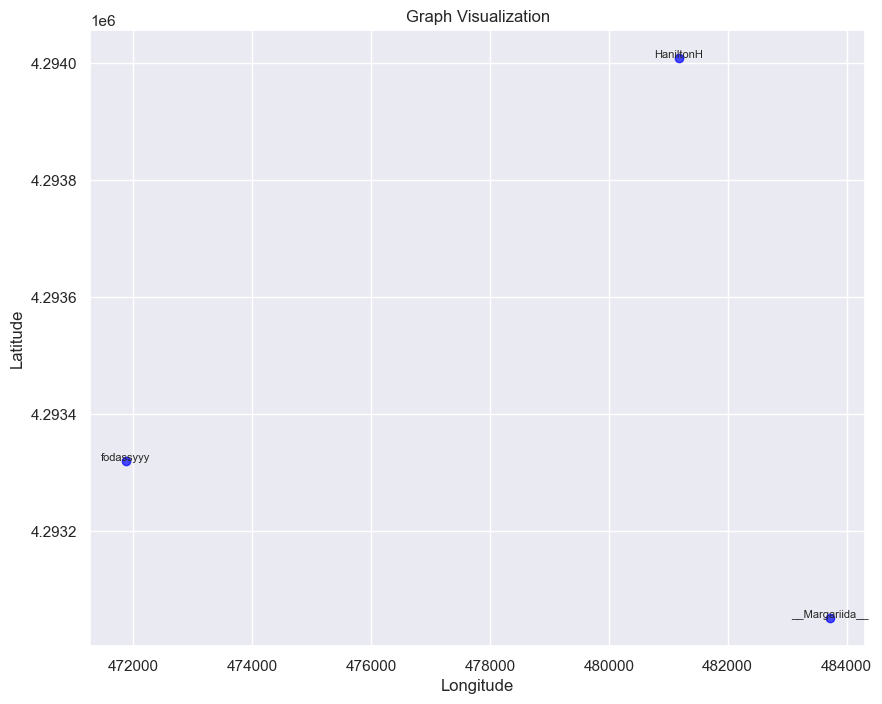

In [80]:
import networkx as nx
import matplotlib.pyplot as plt

# Get the latitude and longitude attributes from the nodes
latitude = nx.get_node_attributes(grafo3, 'median_Y')
longitude = nx.get_node_attributes(grafo3, 'median_X')

# Create a scatter plot of the nodes using latitude and longitude as coordinates
plt.figure(figsize=(10, 8))
plt.scatter(longitude.values(), latitude.values(), color='blue', alpha=0.7)

# Add labels to the nodes
for node, pos in zip(grafo3.nodes(), zip(longitude.values(), latitude.values())):
    plt.annotate(node, pos, fontsize=8, ha='center')

# Set plot title and axis labels
plt.title('Graph Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [79]:
grafo3 = grafo2.copy()
grafo3.remove_node('myrahanda')
# grafo3.remove_node('HaniltonH')

In [ ]:
grafo3 = grafo_twitter_conexo.copy()

for node in grafo_twitter_conexo.nodes():
    if 'median_lat' not in grafo_twitter_conexo.nodes[node]:
        grafo3.remove_node(node)
        
show_graph_metrics(grafo3)

grafo3 = convert_geo_to_utm(grafo3)

In [ ]:
# Get the nodes of grafo2
nodes = list(grafo2.nodes())

# Divide the nodes into 10 sets
sets_of_nodes = np.array_split(nodes, 10)

# Print the sets of nodes
for i, nodes_set in enumerate(sets_of_nodes):
    print(f"Set {i+1}: {nodes_set}")

In [96]:
dispersao = calculate_ward_dispersion(grafo2, latitude='median_Y', longitude='median_X')

print(f"Ward dispersion: {dispersao}")

C:\Users\Cliente\AppData\Local\Temp\ipykernel_17624\3815637868.py:16: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dist_matrix, method='ward')


Ward dispersion: 162590741121140.47


In [102]:
dispersao_inversa = 0

for i, nodes_set in enumerate(sets_of_nodes):
    grafo = grafo2.subgraph(nodes_set)
    num_nodes = grafo.number_of_nodes()
    dispersao = calculate_ward_dispersion(grafo, latitude='median_Y', longitude='median_X')
    dispersao_inversa += 1 / dispersao
    print(f"Set {i+1}: {num_nodes} nodes, inverse Ward dispersion: {1 / dispersao}")
    
print(f"Total inverse Ward dispersion: {dispersao_inversa}")

Set 1: 214 nodes, inverse Ward dispersion: 7.937984709300803e-13
Set 2: 214 nodes, inverse Ward dispersion: 6.303566471518974e-13
Set 3: 214 nodes, inverse Ward dispersion: 7.014055363182985e-13
Set 4: 214 nodes, inverse Ward dispersion: 7.030358161249507e-13
Set 5: 214 nodes, inverse Ward dispersion: 7.235269665727619e-13
Set 6: 214 nodes, inverse Ward dispersion: 8.365374835727652e-13
Set 7: 214 nodes, inverse Ward dispersion: 5.904678590846882e-13
Set 8: 214 nodes, inverse Ward dispersion: 6.819400556339805e-13
Set 9: 214 nodes, inverse Ward dispersion: 6.275328186150861e-13
Set 10: 213 nodes, inverse Ward dispersion: 5.412665033748497e-13
Total inverse Ward dispersion: 6.829868157379359e-12


C:\Users\Cliente\AppData\Local\Temp\ipykernel_17624\3815637868.py:16: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dist_matrix, method='ward')


In [107]:
f_x = (math.log(1/dispersao_inversa) + math.log(D) + math.log(d)) / (math.log(D) - math.log(d))

print(f"Log(f(x)): {math.log(f_x)}")

Log(f(x)): 0.7044814861877651


In [43]:
show_graph_metrics(grafo_twitter_conexo)

Nº de nós: 72800
Nº de links: 120259
Grau médio: 3.303818681318681
Densidade: 2.2691374066392953e-05
Cluster global: 0.002661862925637558
Cluster médio: 0.017752671752988572


In [30]:
# Get the first ten nodes
nodes = list(grafo.nodes())[:10]

# Print the nodes and their attributes
for node in nodes:
    attributes = grafo.nodes[node]
    print(f"Node: {node}")
    print(f"Attributes: {attributes}")
    print("--------------------")

Node: TSFRadio
Attributes: {'median_lat': '38.74751841', 'median_lon': '-9.09904258'}
--------------------
Node: geo_ph
Attributes: {}
--------------------
Node: jccamos
Attributes: {'median_lat': '38.71270596', 'median_lon': '-9.2210118'}
--------------------
Node: iescolar
Attributes: {}
--------------------
Node: ManNextDoor
Attributes: {'median_lat': '38.719345', 'median_lon': '-9.130963195'}
--------------------
Node: Badasstinatas
Attributes: {'median_lat': '38.7321457', 'median_lon': '-9.4126192'}
--------------------
Node: mariana71616477
Attributes: {'median_lat': '38.6560404', 'median_lon': '-9.05134575'}
--------------------
Node: hugocardoso
Attributes: {'median_lat': '38.77876806', 'median_lon': '-9.10261702'}
--------------------
Node: Marco10Melo
Attributes: {}
--------------------
Node: Yoko1904
Attributes: {}
--------------------


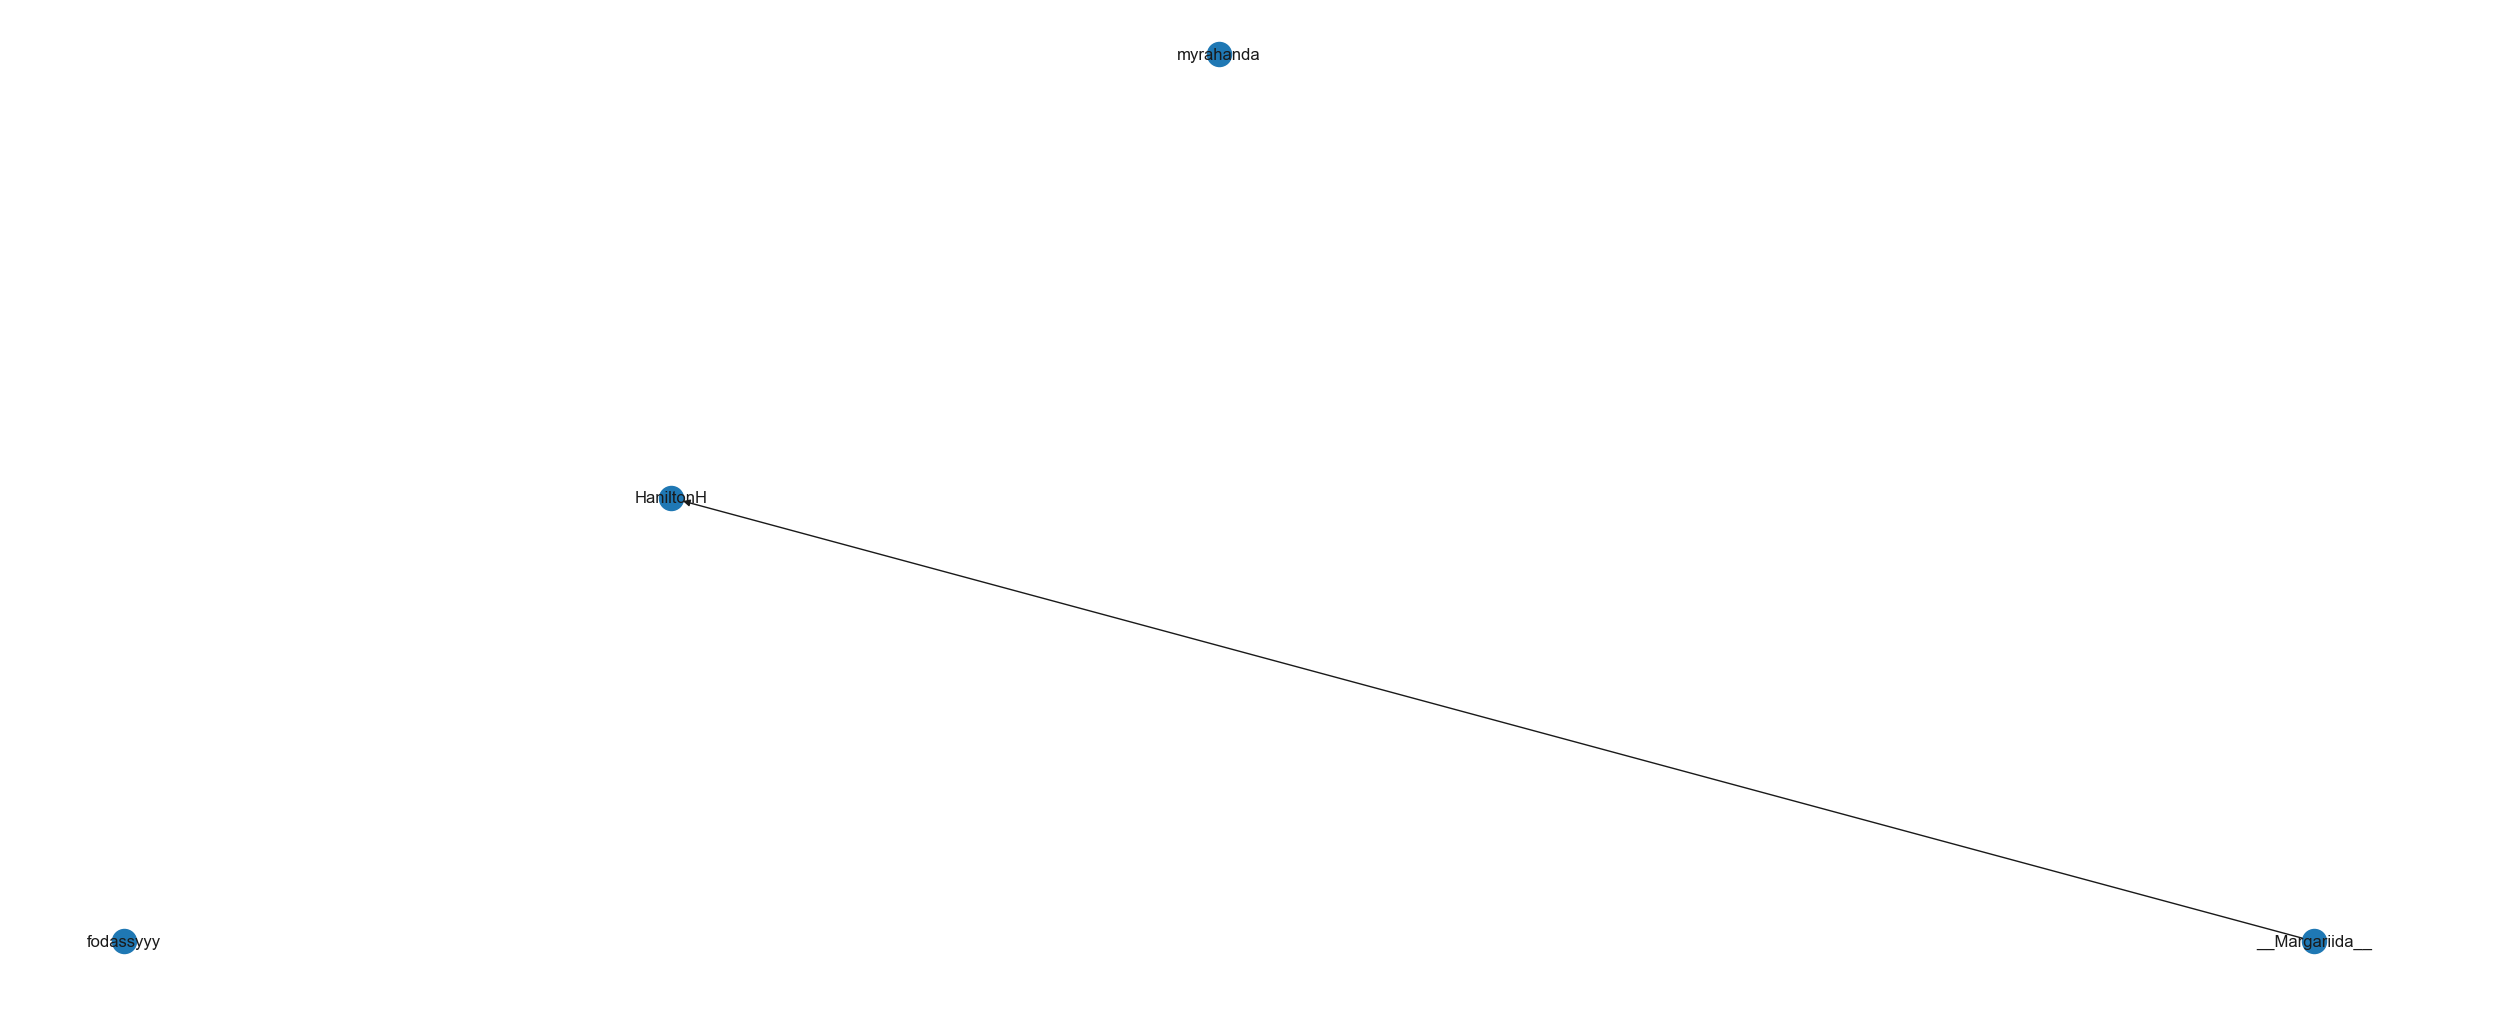

In [13]:
plt.figure(figsize=(25,10))
pos = nx.planar_layout(grafo2)
nx.draw(grafo2, pos=pos, with_labels=True)
plt.show()

In [ ]:
comunidades = list(nx.community.girvan_newman(grafo))

In [ ]:
for comunidade in comunidades:
    modularity_partition = nx.community.modularity(grafo, comunidade)
    print(len(comunidade), modularity_partition)

In [ ]:
# Modularity -> measures the strength of division of a network into modules
modularity_df = pd.DataFrame(
    [
        [k + 1, nx.community.modularity(grafo, comunidades[k])]
        for k in range(len(comunidades))
    ],
    columns=["k", "modularity"],
)

In [ ]:
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "#BCC6C8"][:number_of_colors]
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

In [ ]:
# function to plot graph with node colouring based on communities
def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx.community.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    plt.subplot(3, 1, i)
    plt.title(title)
    nx.draw(
        graph,
        pos=pos,
        node_size=1000,
        node_color=node_colors,
        with_labels=True,
        font_size=20,
        font_color="black",
    )

In [ ]:
fig, ax = plt.subplots(3, figsize=(15, 20))

# Plot graph with colouring based on communities
visualize_communities(grafo, comunidades[0], 1)
visualize_communities(grafo, comunidades[1], 2)

# Plot change in modularity as the important edges are removed
modularity_df.plot.bar(
    x="k",
    ax=ax[2],
    color="#F2D140",
    title="Modularity Trend for Girvan-Newman Community Detection",
)
plt.show()

## Criando as comunidades

### Metodologia de Girvan-Newman

#### Geração

In [ ]:
# Gerando um subgrafo com o maior componente conexo
componentes = nx.weakly_connected_components(grafo_twitter)
maior_componente = max(componentes, key=len)
grafo_twitter_conexo = grafo_twitter.subgraph(maior_componente)

In [ ]:
grafo_twitter_conexo = nx.read_graphml("D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_twitter_conexo.graphml")

In [ ]:
grafo2 = grafo_twitter_conexo.copy()

for u,v in grafo_twitter_conexo.edges():
    if u == v and grafo2.has_edge(u,v):
        grafo2.remove_edge(u,v)
        
    if u['X_']
    

In [ ]:
degrees = []

for node in grafo2.nodes():
    degrees.append(nx.degree(grafo2, node))
    
print(f"Nº de nós: {grafo2.number_of_nodes()}")
print(f"Nº de links: {grafo2.number_of_edges()}")
print(f"Grau médio: {np.mean(degrees)}")
print(f"Densidade: {nx.density(grafo2)}")
print(f"Cluster global: {nx.transitivity(grafo2)}")
print(f"Cluster médio: {nx.average_clustering(grafo2)}")

In [ ]:
# atribuir as comunidades aos nós do grafo
comunidades = list(nx.community.louvain_communities(grafo2))
print(f"Modularidade: {nx.community.modularity(grafo2, comunidades)}")
comunidades_dict = {}
for i, comunidade in enumerate(comunidades):
    for node in comunidade:
        comunidades_dict[node] = i
        
nx.set_node_attributes(grafo2, comunidades_dict, 'comunidade_louvain')

In [ ]:
nx.write_graphml_lxml(grafo_twitter_conexo_20, "D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_twitter_conexo_20.graphml")

In [ ]:
grafo_twitter_20 = nx.read_graphml("D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_twitter_conexo_20.graphml")

In [ ]:
# Gerando um subgrafo com o maior componente conexo
componentes = nx.weakly_connected_components(grafo_twitter_20)
maior_componente = max(componentes, key=len)
grafo_twitter_20_conexo = grafo_twitter_20.subgraph(maior_componente)

In [ ]:
# copy the graph as undirected

grafo_twitter_20_conexo_undirected = grafo_twitter_20_conexo.to_undirected()

In [ ]:
# gerar comunidades Edge Betweeness
comunidades = list(nx.community.edge_betweenness_partition(grafo_twitter_20_conexo_undirected, 101))
print(f"Modularidade: {nx.community.modularity(grafo_twitter_20_conexo_undirected, comunidades)}")
comunidades_dict = {}
for i, comunidade in enumerate(comunidades):
    for node in comunidade:
        comunidades_dict[node] = i
        
nx.set_node_attributes(grafo_twitter_20_conexo_undirected, comunidades_dict, 'comunidade_girvan_newman')

In [ ]:
with open("E://comunidades_greedy_sem_autoloop.txt", "w") as f:
    for comunidade in comunidades:
        f.write(f"{comunidade}\n")

In [ ]:
with open("E://comunidades_greedy_sem_autoloop.txt", "r") as f:
    comunidades = f.readlines()

#### Estatísticas das comunidades

In [ ]:
comunidades = list(nx.community.louvain_communities(grafo_twitter_conexo))
print(f"Modularidade: {nx.community.modularity(grafo_twitter_conexo, comunidades)}")
comunidades_dict = {}
for i, comunidade in enumerate(comunidades):
    for node in comunidade:
        comunidades_dict[node] = i
        
nx.set_node_attributes(grafo_twitter_conexo, comunidades_dict, 'comunidade_louvain')

In [ ]:
remove = [node for node in grafo_twitter_conexo.nodes() if 'median_lat' not in grafo_twitter_conexo.nodes[node]]

In [ ]:
grafo_twitter_conexo.remove_nodes_from(remove)

In [ ]:
show_graph_metrics(grafo_twitter_conexo)

In [ ]:
nodes = list(grafo_twitter_conexo.nodes())[:10]

# Print the nodes and their attributes
for node in nodes:
    attributes = grafo_twitter_conexo.nodes[node]
    print(f"Node: {node}")
    print(f"Attributes: {attributes}")
    print("--------------------")

In [ ]:
estatisticas_grafo = calculate_geostatistics(graph=grafo_twitter_conexo, column='comunidade_louvain')

In [ ]:
myKeys = list(estatisticas_grafo.keys())
myKeys.sort()
sorted_estatisticas_grafo = {i: estatisticas_grafo[i] for i in myKeys}

In [ ]:
text_size_axis = 12
text_size_standart = 16

# Extract the keys and values from the 'estatisticas' dictionary
x = [len(sorted_estatisticas_grafo[key]['x_points']) for key in sorted_estatisticas_grafo.keys()]
y = [sorted_estatisticas_grafo[key]['mean_distance_to_center'] for key in sorted_estatisticas_grafo.keys()]

# Plot the values in bars, y-axis in log
plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Quantidade de nós por comunidade', fontsize=text_size_standart)
plt.ylabel('Distância média ao centro em metros', fontsize=text_size_standart)
plt.title('Dados por comunidade', fontsize=text_size_standart)
plt.xticks(fontsize=text_size_axis)
plt.yticks(fontsize=text_size_axis, rotation=90)
plt.grid(axis='y', color='black')
plt.show()

In [ ]:
text_size_axis = 48
text_size_standart = 52

# Extract the mean and standard deviation from estatisticas
means = [sorted_estatisticas_grafo[key]['mean_distance_to_center'] for key in sorted_estatisticas_grafo.keys()]
stds = [sorted_estatisticas_grafo[key]['standard_deviation'] for key in sorted_estatisticas_grafo.keys()]

# Create a list of community names
community_names = [str(community) for community in sorted_estatisticas_grafo]

plt.figure(figsize=(100, 30))
# Plot the mean with error bars representing the standard deviation
plt.errorbar(community_names, means, yerr=stds, fmt='o', capsize=5, label='Média e Desvio Padrão', ecolor='red', elinewidth=2, capthick=2, markersize=10)

# Set the labels and title
plt.xlabel('Communidade', fontsize=text_size_standart)
plt.ylabel('Distância média ao centro em metros', fontsize=text_size_standart)
plt.xticks(fontsize=text_size_axis*.5)
plt.yticks(fontsize=text_size_axis, rotation=90)
plt.title('Distância média ao centro por comunidade', fontsize=text_size_standart)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)



plt.legend(fontsize=text_size_standart)  # Adiciona a legenda
plt.show()


#### Visualização

In [ ]:
colors = ['#' + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in range(len(comunidades))]

for i, comunidade in enumerate(comunidades):
    for node in comunidade:
        grafo_twitter_conexo.nodes[node]['comunidade'] = i

In [ ]:
nx.write_graphml_lxml(grafo_twitter_conexo, "D:\\Documentos\\data_and_code\\all_data_lisbon\\grafo_twitter_conexo.graphml")

In [ ]:
pos = nx.nx_agraph.graphviz_layout(grafo_twitter_conexo, prog="dot")

### Metodologia K-Means

#### Geração

In [ ]:
# Get the attributes of each node
attributes = nx.get_node_attributes(grafo_twitter_conexo, 'median_X')
df = pd.DataFrame.from_dict(attributes, orient='index', columns=['median_X'])

# Add additional attributes
df['median_Y'] = nx.get_node_attributes(grafo_twitter_conexo, 'median_Y').values()
df['community_louvain'] = nx.get_node_attributes(grafo_twitter_conexo, 'comunidade_louvain').values()
# df['community_greedy'] = nx.get_node_attributes(grafo_twitter_conexo, 'comunidade_girvan_newman').values()

# Print the dataframe
print(df)


In [ ]:
kmeans = KMeans(n_clusters=167, init='k-means++')
df['comunidade_kMeans'] = kmeans.fit_predict(df[df.columns[0:2]])

#### Visualização

In [ ]:
estatisticas_dataframe = calculate_geostatistics(df=df, column='comunidade_kMeans')

In [ ]:
myKeys = list(estatisticas_dataframe.keys())
myKeys.sort()
sorted_estatisticas_dataframe = {i: estatisticas_dataframe[i] for i in myKeys}

In [ ]:
text_size_axis = 12
text_size_standart = 16

# Extract the keys and values from the 'estatisticas' dictionary
x = [len(sorted_estatisticas_dataframe[key]['x_points']) for key in sorted_estatisticas_dataframe.keys()]
y = [sorted_estatisticas_dataframe[key]['mean_distance_to_center'] for key in sorted_estatisticas_dataframe.keys()]

# Plot the values in bars, y-axis in log
plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.yscale('log')
plt.xlabel('Quantidade de nós por comunidade', fontsize=text_size_standart)
plt.ylabel('Distância média ao centro em metros', fontsize=text_size_standart)
plt.title('Dados por comunidade', fontsize=text_size_standart)
plt.xticks(fontsize=text_size_axis)
plt.yticks(fontsize=text_size_axis, rotation=90)
plt.grid(axis='y', color='black')
plt.show()

In [ ]:
text_size_axis = 48
text_size_standart = 52

# Extract the mean and standard deviation from estatisticas
means = [sorted_estatisticas_dataframe[key]['mean_distance_to_center'] for key in sorted_estatisticas_dataframe.keys()]
stds = [sorted_estatisticas_dataframe[key]['standard_deviation'] for key in sorted_estatisticas_dataframe.keys()]

# Create a list of community names
community_names = [str(community) for community in sorted_estatisticas_dataframe]

plt.figure(figsize=(100, 30))
# Plot the mean with error bars representing the standard deviation
plt.errorbar(community_names, means, yerr=stds, fmt='o', capsize=5, label='Média e Desvio Padrão', ecolor='red', elinewidth=2, capthick=2, markersize=10)

# Set the labels and title
plt.xlabel('Communidade', fontsize=text_size_standart)
plt.ylabel('Distância média ao centro em metros', fontsize=text_size_standart)
plt.xticks(fontsize=text_size_axis*.5)
plt.yticks(fontsize=text_size_axis, rotation=90)
plt.title('Distância média ao centro por comunidade', fontsize=text_size_standart)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)



plt.legend(fontsize=text_size_standart)  # Adiciona a legenda
plt.show()

### Metodologia Affinity Propagation

#### Geração

In [ ]:
affinity = AffinityPropagation(preference=0.5)
df['comunidade_affinity'] = affinity.fit_predict(df[df.columns[0:2]])

In [ ]:
estatisticas_affinity = calculate_geostatistics(df=df, column='comunidade_affinity')

In [ ]:
myKeys = list(estatisticas_affinity.keys())
myKeys.sort()
sorted_estatisticas_affinity = {i: estatisticas_affinity[i] for i in myKeys}

#### Visualização

In [ ]:
text_size_axis = 12
text_size_standart = 16

# Extract the keys and values from the 'estatisticas' dictionary
x = [len(sorted_estatisticas_affinity[key]['x_points']) for key in sorted_estatisticas_affinity.keys()]
y = [sorted_estatisticas_affinity[key]['mean_distance_to_center'] for key in sorted_estatisticas_affinity.keys()]

# Plot the values in bars, y-axis in log
plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.yscale('log')
plt.xlabel('Quantidade de nós por comunidade', fontsize=text_size_standart)
plt.ylabel('Distância média ao centro em metros', fontsize=text_size_standart)
plt.title('Dados por comunidade', fontsize=text_size_standart)
plt.xticks(fontsize=text_size_axis)
plt.yticks(fontsize=text_size_axis, rotation=90)
plt.grid(axis='y', color='black')
plt.show()

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=167, linkage='complete')
df['comunidade_aglo'] = agglomerative.fit_predict(df[df.columns[0:2]])

In [ ]:
estatisticas_aglomerado = calculate_geostatistics(df=df, column='comunidade_aglo')

In [ ]:
myKeys = list(estatisticas_aglomerado.keys())
myKeys.sort()
sorted_estatisticas_aglomerado = {i: estatisticas_aglomerado[i] for i in myKeys}

## Visualização Geral

In [ ]:
text_size_axis = 12
text_size_standart = 16

fig, axs = plt.subplots(2, figsize=(15, 15))

fig.suptitle('Comparação de algoritmos de agrupamento', fontsize=text_size_standart)



x = [len(sorted_estatisticas_grafo[key]['x_points']) for key in sorted_estatisticas_grafo.keys()]
y = [sorted_estatisticas_grafo[key]['mean_distance_to_center'] for key in sorted_estatisticas_grafo.keys()]

x2 = [len(sorted_estatisticas_dataframe[key]['x_points']) for key in sorted_estatisticas_dataframe.keys()]
y2 = [sorted_estatisticas_dataframe[key]['mean_distance_to_center'] for key in sorted_estatisticas_dataframe.keys()]

# x2 = [len(sorted_estatisticas_aglomerado[key]['x_points']) for key in sorted_estatisticas_aglomerado.keys()]
# y2 = [sorted_estatisticas_aglomerado[key]['mean_distance_to_center'] for key in sorted_estatisticas_aglomerado.keys()]

# Primeiro gráfico
axs[0].scatter(x, y)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('Quantidade de nós por comunidade', fontsize=text_size_standart)
axs[0].set_ylabel('Distância média ao centro em metros\nLouvain', fontsize=text_size_standart)
axs[0].tick_params(axis='x', labelsize=text_size_axis)
axs[0].tick_params(axis='y', labelsize=text_size_axis, rotation=90)
axs[0].grid(axis='y', color='black')

# Segundo gráfico
axs[1].scatter(x2, y2)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Quantidade de nós por comunidade', fontsize=text_size_standart)
axs[1].set_ylabel('Distância média ao centro em metros\nK Means', fontsize=text_size_standart)
# axs[1].set_title('Dados por comunidade', fontsize=text_size_standart)
axs[1].tick_params(axis='x', labelsize=text_size_axis)
axs[1].tick_params(axis='y', labelsize=text_size_axis, rotation=90)
axs[1].grid(axis='y', color='black')
axs[1].set_ylim(axs[0].get_ylim())

# Terceiro gráfico
# axs[2].scatter(x2, y2)
# axs[2].set_xscale('log')
# axs[2].set_yscale('log')
# axs[2].set_xlabel('Quantidade de nós por comunidade', fontsize=text_size_standart)
# axs[2].set_ylabel('Distância média ao centro em metros\nAglomerativo (Completo)', fontsize=text_size_standart)
# # axs[2].set_title('Dados por comunidade', fontsize=text_size_standart)
# axs[2].tick_params(axis='x', labelsize=text_size_axis)
# axs[2].tick_params(axis='y', labelsize=text_size_axis, rotation=90)
# axs[2].grid(axis='y', color='black')
# axs[2].set_ylim(axs[0].get_ylim())

plt.tight_layout()
plt.show()

In [ ]:
fig2, axs2 = plt.subplots(2, figsize=(100, 100))

text_size_axis = 48
text_size_standart = 52

# Extract the mean and standard deviation from estatisticas
means_louvain = [sorted_estatisticas_grafo[key]['mean_distance_to_center'] for key in sorted_estatisticas_grafo.keys()]
stds_louvain = [sorted_estatisticas_grafo[key]['standard_deviation'] for key in sorted_estatisticas_grafo.keys()]

# Create a list of community names
community_names_louvain = [str(community) for community in sorted_estatisticas_grafo]

means_k_means = [sorted_estatisticas_dataframe[key]['mean_distance_to_center'] for key in sorted_estatisticas_dataframe.keys()]
stds_k_means = [sorted_estatisticas_dataframe[key]['standard_deviation'] for key in sorted_estatisticas_dataframe.keys()]

# Create a list of community names
community_names_k_means = [str(community) for community in sorted_estatisticas_dataframe]

labels_louvain = [label if i % 5 == 0 else '' for i, label in enumerate(community_names_louvain)]
labels_k_means = [label if i % 5 == 0 else '' for i, label in enumerate(community_names_k_means)]


axs2[0].errorbar(community_names_louvain, means_louvain, yerr=stds_louvain, fmt='o', capsize=5, label='Média e Desvio Padrão', ecolor='red', elinewidth=2, capthick=2, markersize=15)

# Set the labels and title
# axs2[0].set_xlabel('Communidade', fontsize=text_size_standart)
axs2[0].set_ylabel('Distância média ao centro em metros', fontsize=text_size_standart)
axs2[0].tick_params(axis='x', labelsize=text_size_axis, rotation=45)
axs2[0].tick_params(axis='y', labelsize=text_size_axis, rotation=90)
axs2[0].set_title('Distância média ao centro por comunidade', fontsize=text_size_standart)
axs2[0].set_xticks(range(len(community_names_louvain)))
axs2[0].set_xticklabels(labels_louvain, rotation=90)
axs2[0].grid(axis='y', color='black')
axs2[0].legend(fontsize=text_size_standart)

# Plot the mean with error bars representing the standard deviation
axs2[1].errorbar(community_names_k_means, means_k_means, yerr=stds_k_means, fmt='o', capsize=5, label='Média e Desvio Padrão', ecolor='red', elinewidth=2, capthick=2, markersize=15)

axs2[1].set_xlabel('Communidade', fontsize=text_size_standart)
axs2[1].set_ylabel('Distância média ao centro em metros', fontsize=text_size_standart)
axs2[1].tick_params(axis='x', labelsize=text_size_axis, rotation=45)
axs2[1].tick_params(axis='y', labelsize=text_size_axis, rotation=90)
axs2[1].set_xticks(range(len(community_names_k_means)))
axs2[1].set_xticklabels(labels_k_means, rotation=90)
# axs2[1].set_title('Distância média ao centro por comunidade', fontsize=text_size_standart)
axs2[1].grid(axis='y', color='black')
axs2[1].legend(fontsize=text_size_standart)
axs2[1].legend(fontsize=text_size_standart)  # Adiciona a legenda

plt.tight_layout()
plt.show()

In [ ]:
df.to_csv('E://df.csv')

In [ ]:
text_size_axis = 12
text_size_standart = 16

# Extract the keys and values from the 'estatisticas' dictionary
x = [len(estatisticas_aglomerado[key]['x_points']) for key in estatisticas_aglomerado.keys()]
y = [estatisticas_aglomerado[key]['mean_distance_to_center'] for key in estatisticas_aglomerado.keys()]

# Plot the values in bars, y-axis in log
plt.figure(figsize=(10, 5))
plt.scatter(x, y)
plt.yscale('log')
plt.xlabel('Quantidade de nós por comunidade', fontsize=text_size_standart)
plt.ylabel('Distância média ao centro em metros', fontsize=text_size_standart)
plt.title('Dados por comunidade', fontsize=text_size_standart)
plt.xticks(fontsize=text_size_axis)
plt.yticks(fontsize=text_size_axis, rotation=90)
plt.grid(axis='y', color='black')
plt.show()

# Fim

In [ ]:
max_edge_secao = max(grafo_fluxo_secao.edges(data=True), key=lambda x: x[2].get('weight', 0))
max_edge_freguesia = max(grafo_fluxo_freguesia.edges(data=True), key=lambda x: x[2].get('weight', 0))
max_edge_municipio = max(grafo_fluxo_municipio.edges(data=True), key=lambda x: x[2].get('weight', 0))

print(f"Fluxo máximo entre seções: {max_edge_secao[0]} -> {max_edge_secao[1]} com {max_edge_secao[2]['weight']} tweets")
print(f"Fluxo máximo entre freguesias: {max_edge_freguesia[0]} -> {max_edge_freguesia[1]} com {max_edge_freguesia[2]['weight']} tweets")
print(f"Fluxo máximo entre municípios: {max_edge_municipio[0]} -> {max_edge_municipio[1]} com {max_edge_municipio[2]['weight']} tweets")

